In [1]:
%matplotlib inline

import sys
import numpy as np
import scipy
import sklearn
import sklearn.datasets
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

tfd = tfp.distributions
psd_kernels = tfp.positive_semidefinite_kernels

sns.set_style('darkgrid')
np.random.seed(42)
# Print versions used
print('Python: {}.{}.{}'.format(*sys.version_info[:3]))
print('Numpy: {}'.format(np.__version__))
print('Tensorflow: {}'.format(tf.__version__))
print('Tensorflow Probability: {}'.format(tfp.__version__))
print('sklearn: {}'.format(sklearn.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('seaborn: {}'.format(sns.__version__))
#

Python: 3.6.6
Numpy: 1.14.5
Tensorflow: 1.11.0
Tensorflow Probability: 0.4.0
sklearn: 0.19.2
matplotlib: 2.2.3
seaborn: 0.9.0


/home/peter/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/peter/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/peter/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/peter/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


- https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/GaussianProcessRegressionModel
- https://www.tensorflow.org/probability/api_docs/python/tfp/positive_semidefinite_kernels
- https://github.com/tensorflow/probability/tree/master/tensorflow_probability/python/positive_semidefinite_kernels

In [2]:
EPS = 1e-6

In [3]:
# Define the true function that we want to regress on
f_sin = lambda x: (np.sin(x)).flatten()

n1 = 50  # Number of points to condition on (training points)
n2 = 100
domain = (-10, 10)

# Sample some points (X1, y1) on the function
X1 = np.random.uniform(*domain, size=(n1,1))
y1 = f_sin(X1)
noise = 0.1 # The variance of the noise
# Add noise to the samples we sampled previously
y1_noisy = np.expand_dims(
    y1 + noise * np.random.randn(n1), 1)

print('X1: ', X1.shape)
print('y1_noisy: ', y1_noisy.shape)

X1:  (50, 1)
y1_noisy:  (50, 1)


X2:  (100, 1)


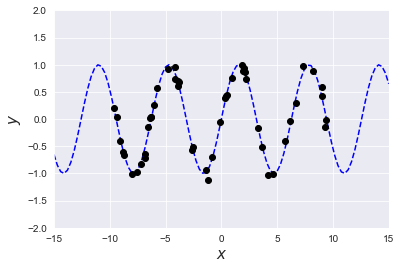

In [4]:
# Predict points at uniform spacing to capture function
domain_plot = (-15, 15)
X2 = np.linspace(*domain_plot, n2).reshape(-1,1)
print('X2: ', X2.shape)

# Plot the postior distribution and some samples
fig, ax1 = plt.subplots(nrows=1, ncols=1)
# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, f_sin(X2), 'b--', label='$sin(x)$')
ax1.plot(X1, y1_noisy, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax1.set_xlabel('$x$', fontsize=15)
ax1.set_ylabel('$y$', fontsize=15)
ax1.axis([*domain_plot, -2, 2])
plt.show()
#

observation_index_points:  (50, 1)
observations:  (50,)
index_points:  (100, 1)
Step 0: NLL = 31.609323483219264
Step 100: NLL = -11.733867470225178
Step 200: NLL = -12.6252501507702
Step 300: NLL = -12.694412905570303
Step 400: NLL = -12.697251803392362
Step 500: NLL = -12.697292770866966
Step 600: NLL = -12.697293950423202
Step 700: NLL = -12.697292209377423
Step 800: NLL = -12.697262354323044
Step 900: NLL = -12.656267600714273
Final NLL = -12.69729500210812


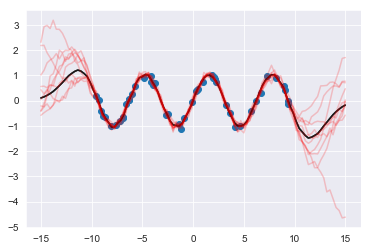

In [6]:
# Optimize model parameters via maximum marginal likelihood

# Suppose we have some data from a known function. Note the index points in
# general have shape `[b1, ..., bB, f1, ..., fF]` (here we assume `F == 1`),
# so we need to explicitly consume the feature dimensions (just the last one
# here).
# f = lambda x: np.sin(10*x[..., 0]) * np.exp(-x[..., 0]**2)

# observation_index_points = np.random.uniform(-1., 1., 50)[..., np.newaxis]
observation_index_points = X1
print('observation_index_points: ', observation_index_points.shape)
# observations = f(observation_index_points) + np.random.normal(0., .05, 50)
observations = y1_noisy.squeeze()
print('observations: ', observations.shape)

# Define a kernel with trainable parameters. Note we transform the trainable
# variables to apply a positivity constraint.
amplitude = tf.exp(tf.Variable(np.float64(0)), name='amplitude')
length_scale = tf.exp(tf.Variable(np.float64(0)), name='length_scale')
amplitude_per = tf.exp(tf.Variable(np.float64(0)), name='amplitude')
length_scale_per = tf.exp(tf.Variable(np.float64(0)), name='length_scale')
# kernel = psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)
# kernel = psd_kernels.ExpSinSquared(amplitude, length_scale)
kernel = (
    psd_kernels.ExpSinSquared(amplitude_per, length_scale_per) * 
    psd_kernels.ExponentiatedQuadratic(amplitude, length_scale))

observation_noise_variance = tf.exp(
    tf.Variable(np.float64(-5)), name='observation_noise_variance')

# We'll use an unconditioned GP to train the kernel parameters.
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=observation_index_points,
    observation_noise_variance=observation_noise_variance)
neg_log_likelihood = -gp.log_prob(observations)

optimizer = tf.train.AdamOptimizer(learning_rate=.05, beta1=.5, beta2=.99)
optimize = optimizer.minimize(neg_log_likelihood)

# We can construct the posterior at a new set of `index_points` using the same
# kernel (with the same parameters, which we'll optimize below).
# index_points = np.linspace(-1., 1., 100)[..., np.newaxis]
index_points = X2
print('index_points: ', index_points.shape)
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=index_points,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

samples = gprm.sample(10)
mean = gprm.mean()
# ==> 10 independently drawn, joint samples at `index_points`.

# Now execute the above ops in a Session, first training the model
# parameters, then drawing and plotting posterior samples.
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(1000):
        _, neg_log_likelihood_ = sess.run([optimize, neg_log_likelihood])
        if i % 100 == 0:
            print("Step {}: NLL = {}".format(i, neg_log_likelihood_))

    print("Final NLL = {}".format(neg_log_likelihood_))
    samples_ = sess.run(samples)
    mean_ = sess.run(mean)

    plt.scatter(np.squeeze(observation_index_points), observations)
    plt.plot(np.stack([index_points[:, 0]]*10).T, mean_.T, c='k', alpha=.2)
    plt.plot(np.stack([index_points[:, 0]]*10).T, samples_.T, c='r', alpha=.2)
plt.show()